In [6]:
import numpy as np
import matplotlib.pyplot as plt

import math
erf = np.vectorize(math.erf)
from b_spline import B_spline



def bake_cake(max_radius, orientation, angle, resolution=(256,256), freq_max=.5, cake_type='basic'):
    '''
        Generate cake wavelet mask
    '''

    X,Y = create_mesh(resolution)

    radial_coord, angular_coord = transform_cartesian_to_radial(X,Y)
    
    assert radial_coord.shape == angular_coord.shape
    assert np.alltrue(angular_coord>0)

    if cake_type == 'basic':
        values = basic_cake(radial_coord, angular_coord, orientation, angle, freq_max)
    elif cake_type == 'b_spline':
        values = b_spline_cake(radial_coord, angular_coord, orientation, angle, freq_max)


    X,Y = transform_radial_to_cartesian(radial_coord, angular_coord)
    return np.stack([X, Y, values])

def create_mesh(resolution):
    '''
        Create a coordinate grid
    '''
    x_dim, y_dim = resolution
    
    X = np.linspace(-1, 1, x_dim)
    X = X[:, None].repeat(y_dim, axis=1)

    Y = np.linspace(-1, 1, y_dim)
    Y = Y[None, :].repeat(X.shape[0], axis=0)
    return X, Y

def b_spline_cake(  radial_coord, angular_coord, orientation, angle, freq_max, 
                    b_n = B_spline(2), radial_boundary_strength=10):
    '''
        Creates soft-boundary cake wavelet filters
    '''
    # Shift center of spline to orientation
    shifted = (angular_coord-orientation + np.pi)%(2*np.pi) - np.pi

    # Use erfc to create a soft radial boundary
    radial_boundary = (1-erf(radial_boundary_strength*(radial_coord-freq_max)))
    values = b_n(shifted) * radial_boundary
    
    return values

def basic_cake(radial_coord, angular_coord, orientation, angle, freq_max):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(angular_coord.shape)
    start = (orientation - angle/2) % (2*np.pi)
    end = (orientation + angle/2) % (2*np.pi)
    if start>=end:
        # Catch if the angle overflows and loops around
        angle_idx = np.logical_or(start < angular_coord, angular_coord < end)
        radial_idx = radial_coord<freq_max
        idx = np.logical_and(angle_idx, radial_idx)
        values[idx] = 1
    else:
        # Between start and last
        angle_idx = np.logical_and(start < angular_coord, angular_coord < end)
        radial_idx = radial_coord<freq_max
        idx = np.logical_and(angle_idx,radial_idx)
        values[idx] = 1
    return values

def calculate_boundaries(max_radius, slices, radius_ticks):
    '''
        Calculates the orientation points for visualization
    '''
    radial_coord = np.arange(0, max_radius, radius_ticks)
    radial_coord = radial_coord[:, None].repeat(slices, axis=1)

    angular_coord = np.linspace(0, 360, slices, endpoint=False)
    angular_coord = angular_coord[:, None].repeat(radial_coord.shape[0], axis=1).T

    assert radial_coord.shape == angular_coord.shape

    values = np.ones(angular_coord.shape)

    X,Y = transform_radial_to_cartesian(radial_coord, angular_coord, degrees=True)
    
    return np.stack([X, Y])

def transform_cartesian_to_radial(X, Y):
    '''
        Convert to polar coordinates
        Input:
            X : x-domain discretized into N bins repeated M times (N x M)
            Y : y-domain discretized into M bins repeated N times (N x M)
        Return:
            r : The corresponding radial coordinate
            theta : The corresponding angular coordinate
    '''
    r = np.sqrt(X**2 + Y**2)
    ang = np.arctan2(X,Y) + np.pi
    return r, ang

def transform_radial_to_cartesian(rad, ang, degrees=False):
    '''
        Convert to Cartesian coordinates
        Input:
            r : The corresponding radial coordinate
            theta : The corresponding angular coordinate
        Return:
            X : x coordinate
            Y : y coordinate
    '''
    ang = ang
    if degrees==True:
        ang = np.deg2rad(ang)
    X = rad*np.cos(ang)
    Y = rad*np.sin(ang)
    return X, Y


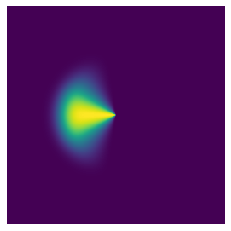

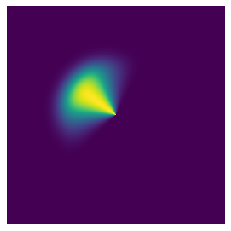

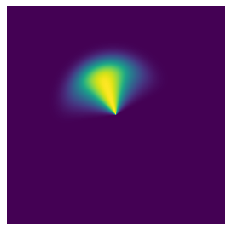

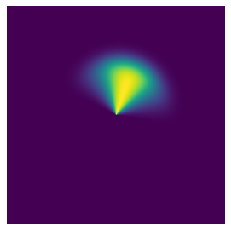

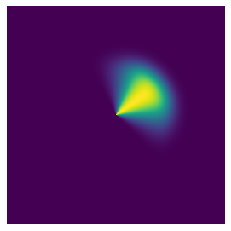

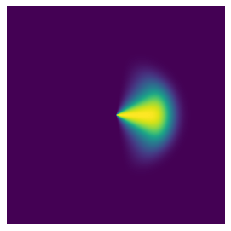

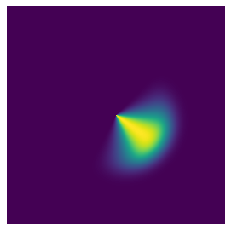

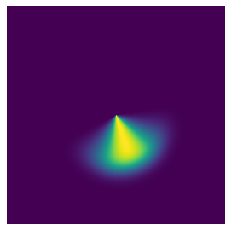

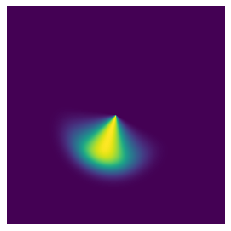

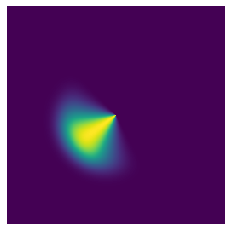

<Figure size 432x288 with 0 Axes>

In [7]:
slices = 10
angle = 2*np.pi/slices
angles = np.linspace(0,2*np.pi, slices, endpoint=False)
filenames = []

for i, orientation in enumerate(angles):
    X, Y, val = bake_cake(1, orientation, angle, cake_type='b_spline')

    bx, by = calculate_boundaries(1, slices, radius_ticks=.5)

    plt.imshow(val*255)
    plt.axis('off')

    filenames+=['/Thesis/images/cake_'+str(i) +'.png']
    plt.savefig('/Thesis/images/cake_'+str(i) +'.png')
    plt.show()
    plt.clf()

import imageio
with imageio.get_writer('./cake.gif', mode='I', duration=.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)